# Example 4: Pareto surface

This example kicks up the complexity a couple of notches. We will introduce a new optimisation estimator, `NearOptimalCentering` optimiser.

In [1]:
using PortfolioOptimisers, PrettyTables
# Format for pretty tables.
tsfmt = (v, i, j) -> begin
    if j == 1
        return Date(v)
    else
        return v
    end
end;
resfmt = (v, i, j) -> begin
    if j == 1
        return v
    else
        return isa(v, Number) ? "$(round(v*100, digits=3)) %" : v
    end
end;

## 1. ReturnsResult data

We will use the same data as the previous example.

In [2]:
using CSV, TimeSeries, DataFrames

X = TimeArray(CSV.File(joinpath(@__DIR__, "SP500.csv.gz")); timestamp = :Date)[(end - 252):end]
pretty_table(X[(end - 5):end]; formatters = tsfmt)

# Compute the returns
rd = prices_to_returns(X)

┌────────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┐
│  timestamp │    AAPL │     AMD │     BAC │     BBY │     CVX │      GE │      HD │     JNJ │     JPM │      KO │     LLY │     MRK │    MSFT │     PEP │     PFE │      PG │     RRC │     UNH │     WMT │     XOM │
│ Dates.Date │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 2022-12-20 │ 131.916 │   65.05 │  31.729 │  77.371 │ 169.497 │  62.604 │ 310.342 │ 173.109 │ 127.844 │  61.841 │  357.55 │ 108.229 │  240.

ReturnsResult
    nx ┼ 20-element Vector{String}
     X ┼ 252×20 Matrix{Float64}
    nf ┼ nothing
     F ┼ nothing
    ts ┼ 252-element Vector{Dates.Date}
    iv ┼ nothing
  ivpa ┴ nothing


## 2. Preparing solvers for pareto surface

The pareto surface is a generalisation of the efficient frontier, in fact, we can even think of hypersurfaces if we provide more parameters, but that would be difficult to visualise, so we will stick to a 2D surface in 3D space.

We'll provide a vector of solvers because the optimisation type we'll be using is more complex, and will contain various constraints.

In [3]:
using Clarabel
slv = [Solver(; name = :clarabel1, solver = Clarabel.Optimizer,
              settings = Dict("verbose" => false),
              check_sol = (; allow_local = true, allow_almost = true)),
       Solver(; name = :clarabel2, solver = Clarabel.Optimizer,
              settings = Dict("verbose" => false, "max_step_fraction" => 0.95),
              check_sol = (; allow_local = true, allow_almost = true)),
       Solver(; name = :clarabel3, solver = Clarabel.Optimizer,
              settings = Dict("verbose" => false, "max_step_fraction" => 0.9),
              check_sol = (; allow_local = true, allow_almost = true)),
       Solver(; name = :clarabel4, solver = Clarabel.Optimizer,
              settings = Dict("verbose" => false, "max_step_fraction" => 0.85),
              check_sol = (; allow_local = true, allow_almost = true)),
       Solver(; name = :clarabel5, solver = Clarabel.Optimizer,
              settings = Dict("verbose" => false, "max_step_fraction" => 0.8),
              check_sol = (; allow_local = true, allow_almost = true)),
       Solver(; name = :clarabel6, solver = Clarabel.Optimizer,
              settings = Dict("verbose" => false, "max_step_fraction" => 0.75),
              check_sol = (; allow_local = true, allow_almost = true)),
       Solver(; name = :clarabel7, solver = Clarabel.Optimizer,
              settings = Dict("verbose" => false, "max_step_fraction" => 0.70),
              check_sol = (; allow_local = true, allow_almost = true))];

## 3. High order prior statistics

We will once again precompute the prior statistics because otherwise they'd have to be recomputed a few times.

We will be using high order risk measures, so we need to compute high order moments, we can do this with a `HighOrderPriorEstimator`, which needs a prior estimator that computes low order moments. Since we are only using a year of data, we will denoise our positive definite matrices by eliminating the eigenvalues corresponding to random noise. Denoising the non-positive definite matrix for the data we're using creates a negative square root, so we will not denoise it.

Note how many options this estimator contains.

In [4]:
de = Denoise(; alg = SpectralDenoise(;))
mp = DefaultMatrixProcessing(; denoise = de)
pe = HighOrderPriorEstimator(;
                             # Prior estimator for low order moments
                             pe = EmpiricalPrior(;
                                                 ce = PortfolioOptimisersCovariance(;
                                                                                    mp = mp)),
                             # Estimator for cokurtosis
                             kte = Cokurtosis(; mp = mp),
                             # Estimator for coskewness
                             ske = Coskewness())

HighOrderPriorEstimator
   pe ┼ EmpiricalPrior
      │        ce ┼ PortfolioOptimisersCovariance
      │           │   ce ┼ Covariance
      │           │      │    me ┼ SimpleExpectedReturns
      │           │      │       │   w ┴ nothing
      │           │      │    ce ┼ GeneralCovariance
      │           │      │       │   ce ┼ SimpleCovariance: SimpleCovariance(true)
      │           │      │       │    w ┴ nothing
      │           │      │   alg ┴ Full()
      │           │   mp ┼ DefaultMatrixProcessing
      │           │      │       pdm ┼ Posdef
      │           │      │           │   alg ┴ UnionAll: NearestCorrelationMatrix.Newton
      │           │      │   denoise ┼ Denoise
      │           │      │           │      alg ┼ SpectralDenoise()
      │           │      │           │     args ┼ Tuple{}: ()
      │           │      │           │   kwargs ┼ @NamedTuple{}: NamedTuple()
      │           │      │           │   kernel ┼ typeof(AverageShiftedHistograms.Kernels.

Let's compute the prior statistics.

In [5]:
pr = prior(pe, rd)

HighOrderPrior
    pr ┼ LowOrderPrior
       │         X ┼ 252×20 Matrix{Float64}
       │        mu ┼ 20-element Vector{Float64}
       │     sigma ┼ 20×20 Matrix{Float64}
       │      chol ┼ nothing
       │         w ┼ nothing
       │       ens ┼ nothing
       │       kld ┼ nothing
       │        ow ┼ nothing
       │        rr ┼ nothing
       │      f_mu ┼ nothing
       │   f_sigma ┼ nothing
       │       f_w ┴ nothing
    kt ┼ 400×400 Matrix{Float64}
    L2 ┼ 210×400 SparseArrays.SparseMatrixCSC{Int64, Int64}
    S2 ┼ 210×400 SparseArrays.SparseMatrixCSC{Int64, Int64}
    sk ┼ 20×400 Matrix{Float64}
     V ┼ 20×20 Matrix{Float64}
  skmp ┼ DefaultMatrixProcessing
       │       pdm ┼ Posdef
       │           │   alg ┴ UnionAll: NearestCorrelationMatrix.Newton
       │   denoise ┼ nothing
       │    detone ┼ nothing
       │       alg ┴ nothing


In order to generate a pareto surface/hyper-surface, we need more dimensions than we've previously explored. We can do this by adding more risk measure sweeps (and taking their product) to generate a mesh. `PortfolioOptimisers` does this internally and generally, but we will limit ourselves to two risk measures. This will generate a 2D surface which we can visualise in 3D.

We will use the square root `NegativeSkewness` and `Kurtosis`.

In [6]:
r1 = NegativeSkewness()
r2 = Kurtosis()

Kurtosis
  settings ┼ RiskMeasureSettings
           │   scale ┼ Float64: 1.0
           │      ub ┼ nothing
           │     rke ┴ Bool: true
         w ┼ nothing
        mu ┼ nothing
        kt ┼ nothing
         N ┼ nothing
       alg ┴ Full()


## 4. Near optimal centering pareto surface

First we need to get the bounds of our pareto surface. We can do this in many different ways, the simplest are:

  - Minimise the risk using both risk measures simultaneously subject to optional constraints.
  - Maximise the return, utility or ratio subject to optional constraints.

We will simply maximise the risk-return ratio for both risk measures on their own with no added constraints. This will not give a complete surface, but it will give us a reasonable range of values.

The `NearOptimalCentering` estimator will not return the portfolio which satisfies the traditional `MeanRisk` constraints, but rather a portfolio which is at the centre of an analytical region (neighbourhood) around the optimal solution. The region is parametrised by binning the efficient frontier, we will use the automatic bins here, but it is possible to define them manually.

In [7]:
# Risk-free rate of 4.2/100/252
rf = 4.2 / 100 / 252
opt = JuMPOptimiser(; pe = pr, slv = slv)
obj = MaximumRatio(; rf = rf)
opt1 = NearOptimalCentering(; r = r1, obj = obj, opt = opt)
opt2 = NearOptimalCentering(; r = r2, obj = obj, opt = opt)

NearOptimalCentering
        opt ┼ JuMPOptimiser
            │       pe ┼ HighOrderPrior
            │          │     pr ┼ LowOrderPrior
            │          │        │         X ┼ 252×20 Matrix{Float64}
            │          │        │        mu ┼ 20-element Vector{Float64}
            │          │        │     sigma ┼ 20×20 Matrix{Float64}
            │          │        │      chol ┼ nothing
            │          │        │         w ┼ nothing
            │          │        │       ens ┼ nothing
            │          │        │       kld ┼ nothing
            │          │        │        ow ┼ nothing
            │          │        │        rr ┼ nothing
            │          │        │      f_mu ┼ nothing
            │          │        │   f_sigma ┼ nothing
            │          │        │       f_w ┴ nothing
            │          │     kt ┼ 400×400 Matrix{Float64}
            │          │     L2 ┼ 210×400 SparseArrays.SparseMatrixCSC{Int64, Int64}
            │          │

Note the number of options in the estimator. In particular the `alg` property. Which in this case means the `NearOptimalCentering` alg will not have any external constraints applied to it.

Let's optimise the portfolios.

In [8]:
res1 = optimise(opt1)
res2 = optimise(opt2)

NearOptimalCenteringOptimisation
             oe ┼ DataType: DataType
             pa ┼ ProcessedJuMPOptimiserAttributes
                │       pr ┼ HighOrderPrior
                │          │     pr ┼ LowOrderPrior
                │          │        │         X ┼ 252×20 Matrix{Float64}
                │          │        │        mu ┼ 20-element Vector{Float64}
                │          │        │     sigma ┼ 20×20 Matrix{Float64}
                │          │        │      chol ┼ nothing
                │          │        │         w ┼ nothing
                │          │        │       ens ┼ nothing
                │          │        │       kld ┼ nothing
                │          │        │        ow ┼ nothing
                │          │        │        rr ┼ nothing
                │          │        │      f_mu ┼ nothing
                │          │        │   f_sigma ┼ nothing
                │          │        │       f_w ┴ nothing
                │          │     kt ┼ 4

In order to allow for multiple risk measures in optimisations, certain measures can take different parameters. In this case, `NegativeSkewness` and `Kurtosis` take the moment matrices, which are used to compute the risk measures. We can use the `factory` function to create a new risk measure with the same parameters as the original, but with the moment matrices from the prior. Other risk measures require a solver, and this function is also used in those cases.

In [9]:
r1 = factory(r1, pr)
r2 = factory(r2, pr)

Kurtosis
  settings ┼ RiskMeasureSettings
           │   scale ┼ Float64: 1.0
           │      ub ┼ nothing
           │     rke ┴ Bool: true
         w ┼ nothing
        mu ┼ 20-element Vector{Float64}
        kt ┼ 400×400 Matrix{Float64}
         N ┼ nothing
       alg ┴ Full()


Let's compute the risk bounds for the pareto surface. We need to compute four risks because we have two risk measures and two optimisations. This will let us pick the lower and upper bounds for each risk measure, as we explore the pareto surface from one optimisation to the other.

In [10]:
sk_rk1 = expected_risk(r1, res1.w, pr.X);
kt_rk1 = expected_risk(r2, res1.w, pr.X);
sk_rk2 = expected_risk(r1, res2.w, pr.X);
kt_rk2 = expected_risk(r2, res2.w, pr.X);

We will now create new risk measures bounded by these values. We will also use factories from the get-go. The optimisation procedure prioritises the parameters in the risk measures over the ones in the prior. This lets users provide the same risk measure with different parameters in the same optimisation. We will use two ranges of 5. The total number of points in the pareto surface will be the product of the points of each range.

Since we don't know which `sk_rk1` or `sk_r2`, `kt_rk1` or `kt_rk2` is bigger or smaller, we need to use `min`, `max`.

In [11]:
r1 = factory(NegativeSkewness(;
                              settings = RiskMeasureSettings(;
                                                             # Risk upper bounds go from the minimum to maximum risk given the optimisations.
                                                             ub = range(;
                                                                        start = min(sk_rk1,
                                                                                    sk_rk2),
                                                                        stop = max(sk_rk1,
                                                                                   sk_rk2),
                                                                        length = 5))), pr);
r2 = factory(Kurtosis(;
                                settings = RiskMeasureSettings(;
                                                               ub = range(;
                                                                          start = min(kt_rk1,
                                                                                      kt_rk2),
                                                                          stop = max(kt_rk1,
                                                                                     kt_rk2),
                                                                          length = 5))), pr);

Now we only need to maximise the return given both risk measures. Internally, the optimisation will generate the mesh as a product of the ranges in the order in which the risk measures were provided. This also works with the `MeanRisk` estimator, in fact, `NearOptimalCentering` uses it internally.

Since we are using an unconstrained `NearOptimalCentering`, the risk bound constraints will not be satisfied by the solution. If we wish to satisfy them, we can provide `alg = ConstrainedNearOptimalCentering()`, but would also make the optimisations harder, which may cause them to fail.

In [12]:
opt3 = NearOptimalCentering(; r = [r1, r2], obj = MaximumReturn(), opt = opt)

NearOptimalCentering
        opt ┼ JuMPOptimiser
            │       pe ┼ HighOrderPrior
            │          │     pr ┼ LowOrderPrior
            │          │        │         X ┼ 252×20 Matrix{Float64}
            │          │        │        mu ┼ 20-element Vector{Float64}
            │          │        │     sigma ┼ 20×20 Matrix{Float64}
            │          │        │      chol ┼ nothing
            │          │        │         w ┼ nothing
            │          │        │       ens ┼ nothing
            │          │        │       kld ┼ nothing
            │          │        │        ow ┼ nothing
            │          │        │        rr ┼ nothing
            │          │        │      f_mu ┼ nothing
            │          │        │   f_sigma ┼ nothing
            │          │        │       f_w ┴ nothing
            │          │     kt ┼ 400×400 Matrix{Float64}
            │          │     L2 ┼ 210×400 SparseArrays.SparseMatrixCSC{Int64, Int64}
            │          │

See how `r` is a vector of risk measures with populated properties. We can now optimise the portfolios.

In [13]:
res3 = optimise(opt3)

NearOptimalCenteringOptimisation
             oe ┼ DataType: DataType
             pa ┼ ProcessedJuMPOptimiserAttributes
                │       pr ┼ HighOrderPrior
                │          │     pr ┼ LowOrderPrior
                │          │        │         X ┼ 252×20 Matrix{Float64}
                │          │        │        mu ┼ 20-element Vector{Float64}
                │          │        │     sigma ┼ 20×20 Matrix{Float64}
                │          │        │      chol ┼ nothing
                │          │        │         w ┼ nothing
                │          │        │       ens ┼ nothing
                │          │        │       kld ┼ nothing
                │          │        │        ow ┼ nothing
                │          │        │        rr ┼ nothing
                │          │        │      f_mu ┼ nothing
                │          │        │   f_sigma ┼ nothing
                │          │        │       f_w ┴ nothing
                │          │     kt ┼ 4

As expected, there are `5 × 5 = 25` solutions. Thankfully there are no warnings about failed optimisations, so there is no need to check the solutions.

The `NearOptimalCentering` estimator contains various return codes because it may need to compute some `MeanRisk` optimisations, it has a `retcode` which summarises whether all other optimisations succeeded. We can check this to make sure it was a success.

In [14]:
isa(res3.retcode, OptimisationSuccess)

true

## 5. Visualising the pareto surface

Let's view how the weights evolve along the pareto surface.

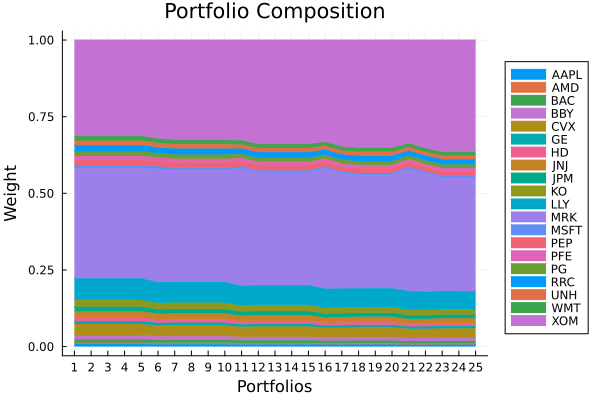

In [15]:
using StatsPlots, GraphRecipes
plot_stacked_area_composition(res3.w, rd.nx)

Now we can view the pareto surface. For the z-axis and colourbar, we will use the conditional drawdown at risk to return ratio.

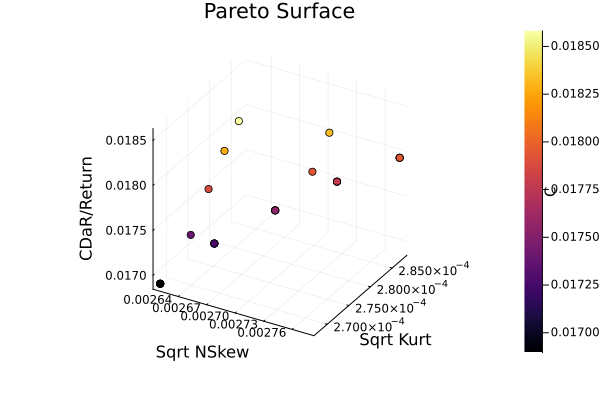

In [16]:
plot_measures(res3.w, pr; x = r1, y = r2,
              z = RatioRiskMeasure(; rk = ConditionalDrawdownatRisk(),
                                   rt = ArithmeticReturn(), rf = rf),
              c = RatioRiskMeasure(; rk = ConditionalDrawdownatRisk(),
                                   rt = ArithmeticReturn(), rf = rf),
              title = "Pareto Surface", xlabel = "Sqrt NSkew", ylabel = "Sqrt Kurt",
              zlabel = "CDaR/Return")

We can view it in 2D as well.

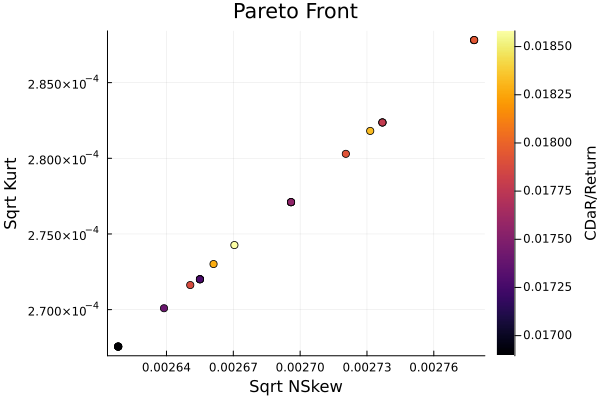

In [17]:
gr()
plot_measures(res3.w, pr; x = r1, y = r2,
              c = RatioRiskMeasure(; rk = ConditionalDrawdownatRisk(),
                                   rt = ArithmeticReturn(), rf = rf),
              title = "Pareto Front", xlabel = "Sqrt NSkew", ylabel = "Sqrt Kurt",
              colorbar_title = "\n\nCDaR/Return", right_margin = 8Plots.mm)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*